# XID+PACS Lockman-SWIRE Prior

In [1]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.table import Table

In [2]:
import seaborn as sns

This notebook uses all the raw data from the XID+PACS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. As the prior for XID+ is based on IRAC detected sources.

In [3]:
Sel_func=pymoc.MOC()
Sel_func.read('../data/Lockman-SWIRE/holes_Lockman-SWIRE_irac1_20171214_O16_MOC.fits')

## Read in XID+MIPS catalogue

In [4]:
XID_MIPS=Table.read('../data/Lockman-SWIRE/MIPS/dmu26_XID+MIPS_Lockman-SWIRE_cat_20171214.fits')

In [5]:
XID_MIPS[0:10]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24
,deg,deg,uJy,uJy,uJy,MJy / sr,MJy / sr,,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool
HELP_J104834.640+553618.070,162.1443344,55.6050193754,953.652,1391.02,558.782,-0.263134,4.94239e-06,1.0021,959.0,0.0,False
HELP_J104844.111+553806.455,162.18379776,55.6351263157,5.835,15.6855,1.42353,-0.124418,5.0304e-06,nan,1428.0,0.0,True
HELP_J104909.113+554129.002,162.287969389,55.6913894849,16.5938,33.347,5.67531,3.73435e-05,4.89605e-06,1.00059,1623.0,0.0,True
HELP_J104910.454+554135.336,162.293559631,55.6931488629,47.5049,66.385,28.2103,3.73435e-05,4.89605e-06,nan,775.0,0.0,False
HELP_J104911.099+554218.548,162.29624584,55.7051523559,187.706,204.257,169.476,-0.00208601,5.06499e-06,1.00105,1615.0,0.0,False
HELP_J104919.290+554303.561,162.330374299,55.7176559469,39.9872,58.7282,22.266,-0.00208601,5.06499e-06,nan,2000.0,0.0,False
HELP_J104916.682+554301.860,162.319507377,55.7171832419,18.1097,33.5374,6.31178,-0.00208601,5.06499e-06,1.00147,1201.0,0.0,True
HELP_J104914.098+554211.057,162.308741513,55.7030714689,270.506,288.916,253.788,-0.00208601,5.06499e-06,nan,1763.0,0.0,False


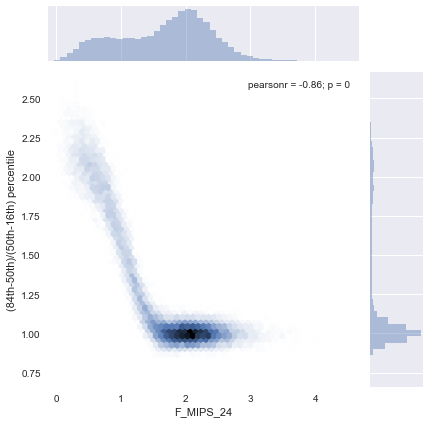

In [6]:
skew=(XID_MIPS['FErr_MIPS_24_u']-XID_MIPS['F_MIPS_24'])/(XID_MIPS['F_MIPS_24']-XID_MIPS['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(XID_MIPS['F_MIPS_24']),y=skew, kind='hex')

The uncertianties become Gaussian by $\sim 20 \mathrm{\mu Jy}$

In [6]:
good=XID_MIPS['F_MIPS_24']>20

In [7]:
good.sum()

249732

## Read in Maps

In [8]:
im100fits='../data/Lockman-SWIRE/PACS/Lockman-SWIRE_PACS100_20160921_img_gls.fits'#PACS 100 map
nim100fits='../data/Lockman-SWIRE/PACS/Lockman-SWIRE_PACS100_20160921_img_noise.fits'#PACS 100 noise map
im160fits='../data/Lockman-SWIRE/PACS/Lockman-SWIRE_PACS160_20160921_img_gls.fits'#PACS 160 map
nim160fits='../data/Lockman-SWIRE/PACS/Lockman-SWIRE_PACS160_20160921_img_noise.fits'#PACS 100 noise map
#output folder
output_folder='./'

In [9]:
from astropy.io import fits
from astropy import wcs

#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist[0].header
im100hdu=hdulist[0].header
im100=hdulist[0].data
w_100 = wcs.WCS(hdulist[0].header)
pixsize100=3600.0*np.abs(hdulist[0].header['CDELT1']) #pixel size (in arcseconds)
hdulist.close()

hdulist = fits.open(nim100fits)
nim100=hdulist[0].data
hdulist.close()

#-----160-------------
hdulist = fits.open(im160fits)
im160phdu=hdulist[0].header
im160hdu=hdulist[0].header

im160=hdulist[0].data #convert to mJy
w_160 = wcs.WCS(hdulist[0].header)
pixsize160=3600.0*np.abs(hdulist[0].header['CDELT1']) #pixel size (in arcseconds)
hdulist.close()

hdulist = fits.open(nim160fits)
nim160=hdulist[0].data
hdulist.close()

## Read in PSF

In [10]:
pacs100_psf=fits.open('../../dmu18/dmu18_Lockman-SWIRE/dmu18_PACS_100_PSF_Lockman-SWIRE_20171214.fits')
pacs160_psf=fits.open('../../dmu18/dmu18_Lockman-SWIRE/dmu18_PACS_160_PSF_Lockman-SWIRE_20171214.fits')

centre100=np.long((pacs100_psf[1].header['NAXIS1']-1)/2)
radius100=15
centre160=np.long((pacs160_psf[1].header['NAXIS1']-1)/2)
radius160=25

pind100=np.arange(0,radius100+1+radius100,1)*3600*np.abs(pacs100_psf[1].header['CDELT1'])/pixsize100 #get 100 scale in terms of pixel scale of map
pind160=np.arange(0,radius160+1+radius160,1)*3600*np.abs(pacs160_psf[1].header['CDELT1'])/pixsize160 #get 160 scale in terms of pixel scale of map

In [11]:
print(pind100)

[  0.           0.33333333   0.66666667   1.           1.33333333
   1.66666667   2.           2.33333333   2.66666667   3.           3.33333333
   3.66666667   4.           4.33333333   4.66666667   5.           5.33333333
   5.66666667   6.           6.33333333   6.66666667   7.           7.33333333
   7.66666667   8.           8.33333333   8.66666667   9.           9.33333333
   9.66666667  10.        ]


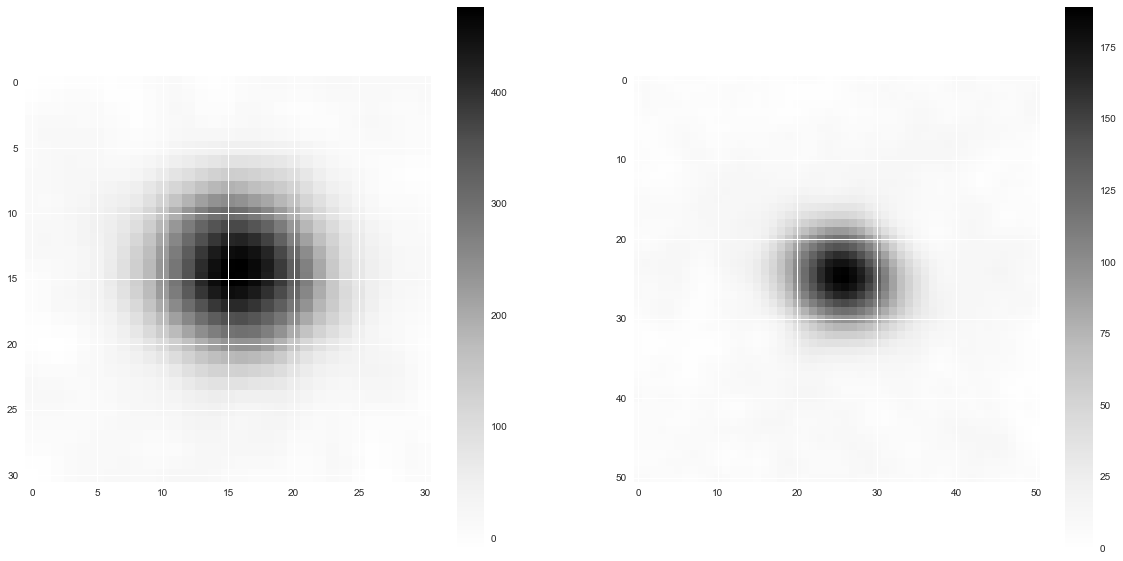

In [12]:
import pylab as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1])
plt.colorbar()

## Set XID+ prior class

In [13]:
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu, moc=Sel_func)#Initialise with map, uncertianty map, wcs info and primary header
prior100.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_Lockman-SWIRE_cat_20171214.fits',ID=XID_MIPS['help_id'][good])#Set input catalogue
prior100.prior_bkg(0.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu, moc=Sel_func)
prior160.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_Lockman-SWIRE_cat_20171214.fits',ID=XID_MIPS['help_id'][good])
prior160.prior_bkg(0.0,5)

In [14]:
# Divide by 1000 so that units are mJy
prior100.set_prf(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1]/1000.0,
                pind100,pind100)
prior160.set_prf(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1]/1000.0,
                pind160,pind160)

In [15]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior100.sra,prior100.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior100.sra,prior100.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./'
xidplus.io.pickle_dump({'priors':[prior100,prior160],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},'Master_prior.pkl')
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 13996 tiles required for input catalogue and 24 large tiles
writing total_bytes=1342530523...
writing bytes [0, 1073741824)... done.
writing bytes [1073741824, 1342530523)... done.


SystemExit: 

In [17]:
ls -ltrh

total 2622552
-rw-rw-r--  1 pdh21  pdh21   111K 15 Dec 13:11 Tiles.pkl
-rw-rw-r--  1 pdh21  pdh21   1.3G 15 Dec 13:11 Master_prior.pkl
-rw-rw-r--  1 pdh21  pdh21    95K 15 Dec 13:12 XID+PACS_prior.ipynb
